# PA2 - NB Classification

In this homework assignment, you will implement a simple Naive Bayes classifier and train/test it on the 20 newsgroup dataset. The objective is to classify documents into one of the 20 categories using a simple Naive Bayesian method.

The following code is partially done. You need to complete all the code blocks that start with **TODO**. Save a copy of this notebook, and complete your notebook. **Submit your completed notebook with all the outputs returned and displayed.**

## Data Analysis
Let's fetch the dataset first. You can download it using a sci-kit learn dataset method as below.

In [547]:
from sklearn.datasets import fetch_20newsgroups

data_tr = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)

Let's inspect what we have.

In [548]:
dir(data_tr)

['DESCR', 'data', 'filenames', 'target', 'target_names']

Let's print out the first three examples.

In [549]:
data_tr.data[:3]

["From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n",
 "From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 

In [550]:
data_tr.target[:3]

array([7, 4, 4])

As you can see, `data` is the textual input, and `target` is the corresponding label (i.e., news category). We have 20 classes as below, and the target is the integer number corresponding to the names:

In [551]:
data_tr.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Let's plot a histogram with the target data to see its distribution.

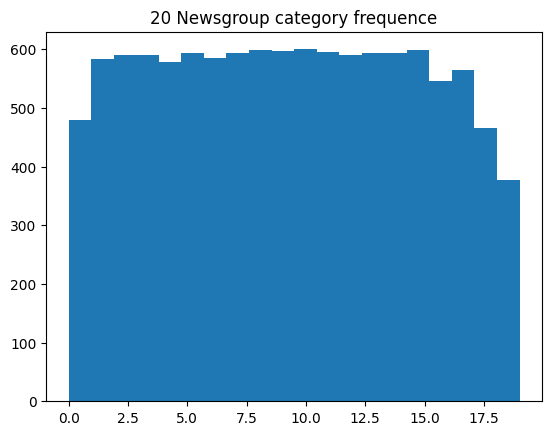

In [552]:
import matplotlib.pyplot as plt

plt.hist(data_tr.target, bins=len(data_tr.target_names))
plt.title("20 Newsgroup category frequence")
plt.show()

## Text preprocessing

From this section, you will complete the unfinished code to make it run as expected. First part is for text preprocessing.

### Filtering of Stopwords and Tokenizing

You will remove stopwords from the raw texts. *Stopwords* are a set of frequently used words in any language, such as 'a', 'you', 'I', and 'will'. These are most likely function words that are not necessarily informative in delivering meanings.

Next, the given texts will be tokenized; that is, a sentence is split into an array of words by whitespace. After that, we can compute the probabilities over words.

So, this is a simple text preprocessing that should:
- convert to lowercase
- filter stopwords, and
- tokenize simply by whitespace.

We can use the NLTK stopwords as below:

In [553]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
sw_list = stopwords.words('english')
sw_list[:10]  # show some examples

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kunal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

**TODO -- Complete the following function; this function takes a string and returns a list of words in lowercase which are not in the stopwords list.**

In [554]:
import string
def text_prep(s):
  # TODO -- write your code here
  output = []
  s = s.translate(str.maketrans('', '', string.punctuation))
  for word in s.split():
    # remove stopwords
    if word not in sw_list:
      # lowercase
      # tokenize
      output.append(str.lower(word))  
  return output


**TODO -- Apply the function `text_prep` on `data_tr.data` and append the outputs to `data_tr_prep`. `data_tr_prep` will be a list of documents where each document is a list of preprocessed words.**

In [555]:
# TODO -- write your code here
data_tr_prep = []
for line in data_tr.data:
  data_tr_prep.append(text_prep(line))
print(data_tr_prep[0])

['from', 'lerxstwamumdedu', 'wheres', 'thing', 'subject', 'what', 'car', 'nntppostinghost', 'rac3wamumdedu', 'organization', 'university', 'maryland', 'college', 'park', 'lines', '15', 'i', 'wondering', 'anyone', 'could', 'enlighten', 'car', 'i', 'saw', 'day', 'it', '2door', 'sports', 'car', 'looked', 'late', '60s', 'early', '70s', 'it', 'called', 'bricklin', 'the', 'doors', 'really', 'small', 'in', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'this', 'i', 'know', 'if', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please', 'email', 'thanks', 'il', 'brought', 'neighborhood', 'lerxst']


`data_tr_prep[0]` should print a list of words similar to the following list:
```
['from:',
 'lerxst@wam.umd.edu',
 "(where's",
 'thing)',
 'subject:',
 'car',
 'this!?',
 'nntp-posting-host:',
 'rac3.wam.umd.edu',
 'organization:',
 'university',
 'maryland,',
 ...
]
```

## Build a Vocabulary

Now we need to build a vocabulary which contains a fixed number of unique words. Only the words in the vocabulary will be used in the prediction process.

Let's set a reasonable size of vocabulary (i.e., V = 10000)

We will use a Python Counter to count all the words appear in the entire *training* dataset. This counter is a dictionary of key-value (word-frequency) pairs.


In [556]:
from collections import Counter, defaultdict
V = 10000
C = len(data_tr.target_names)
cnt_words = Counter()
for d in data_tr_prep:
  cnt_words.update(d)

`.most_common(n)` will return the n most frequent words in the counter, as below: Let's not worry about the punctuation words for now.

In [557]:
cnt_words.most_common(20)

[('i', 40824),
 ('the', 16821),
 ('subject', 12253),
 ('from', 12221),
 ('lines', 11824),
 ('organization', 11185),
 ('in', 9755),
 ('would', 8874),
 ('one', 8654),
 ('re', 7929),
 ('writes', 7836),
 ('article', 6754),
 ('people', 5833),
 ('dont', 5814),
 ('like', 5760),
 ('1', 5554),
 ('university', 5544),
 ('if', 5457),
 ('x', 5457),
 ('know', 5116)]

**TODO -- Build mappings between tokens (words) and their index numbers.**

We create a data structure for the vocabulary of `V` words. You can use `cnt_words.most_common(V)` to get the top V most frequent words.

`tok2idx` should map a token to its index number and `idx2tok` should be a list of words in the frequency order.

In [558]:
idx2tok = list()
tok2idx = dict()
# TODO -- write your code here to populate the idx2tok and tok2idx
vocab = cnt_words.most_common(V)
i = 0

for key, value in vocab:
    idx2tok.append(key)
    tok2idx[key] = i
    i += 1
print(idx2tok[:10])
print(tok2idx['would'])

['i', 'the', 'subject', 'from', 'lines', 'organization', 'in', 'would', 'one', 're']
7


You should see results like below:

```
> idx2tok[:10]

['>',
 'subject:',
 'from:',
 'lines:',
 'organization:',
 '|',
 '-',
 'would',
 're:',
 '--']

> tok2idx['would']

7
 ```

## Training a NB Classifier

Naive Bayes classifier is a simple conditional probability model based on applying Bayes' theorem with strong feature independence assumption. For more details, you should carefully read the lecture slides.

In essense, we need to build a classifier that computes the following:

$$argmax_{c\in C} P(c)\prod_{w\in d} P(w|c)$$

That is, for each class $c$, we compute the product of the class prior $P(c)$ and the conditional probabilities of words given the class $P(w|c)$ in a document $d$.

To do this, we need to estimate the prior class probabilities $P(c)$ and the conditional probabilities $P(w|c)$. We will use the normalized frequencies to estimate these probabilities.

For example, $P(c=rec.autos)$ can be estimated by the number of documents that belong to the class divided it by the total number of documents.

Likewise, $P(w=car|c=rec.autos)$ can be estimated by the fraction of the word $w$ appears among all words in documents of the class $c$.

To handle the zero probability issue, you should also apply the 'add-1' smoothing. See the lecture slides.

Now, the following Numpy arrays (i.e, `cond_prob` and `prior_prob`) will contain the estimated probabilities.

In [559]:
import numpy as np

cond_prob = np.zeros((V, C))
prior_prob = np.zeros((C))

**TODO -- Increment the counts and normalize them properly so that they can be use as the probabilities.**

In [560]:
for d, c in zip(data_tr_prep, data_tr.target):
  # TODO -- Complete this for loop block.
  for t in d:
    if t in tok2idx:
      cond_prob[tok2idx[t], c] += 1
  prior_prob[c] += 1
prior_prob /= np.sum(prior_prob)
cond_prob += 0.1
cond_prob /= (np.sum(cond_prob, axis=0)+V)
print(prior_prob)
print(cond_prob[10])



[0.04242531 0.05161747 0.05223617 0.05214778 0.05108715 0.05241294
 0.05170585 0.05250133 0.05285487 0.05276648 0.05303164 0.05258971
 0.05223617 0.05250133 0.05241294 0.05294326 0.04825879 0.04984974
 0.04109952 0.03332155]
[0.00592864 0.00303951 0.00387564 0.00306786 0.00404635 0.00193785
 0.00099877 0.00598068 0.00668287 0.00560753 0.00359015 0.00349056
 0.0039395  0.00433756 0.00426079 0.00329662 0.00438228 0.00376177
 0.00519524 0.00461936]


`prior_prob` should look something like this:

```
array([0.04242531, 0.05161747, 0.05223617, 0.05214778, 0.05108715,
       0.05241294, 0.05170585, 0.05250133, 0.05285487, 0.05276648,
       0.05303164, 0.05258971, 0.05223617, 0.05250133, 0.05241294,
       0.05294326, 0.04825879, 0.04984974, 0.04109952, 0.03332155])
```

`cond_prob[10]` should look something like this:

```
array([0.00802263, 0.00404768, 0.00520794, 0.00410638, 0.00516728,
       0.00250812, 0.00143359, 0.0081197 , 0.00944117, 0.00747272,
       0.00482113, 0.00474687, 0.0053405 , 0.00616861, 0.00579096,
       0.00451822, 0.00591574, 0.00497174, 0.00676319, 0.00629697])
```

## Inference

You will test your classifier with unseen examples (test dataset).

**TODO -- Apply `text_prep` on `data_ts` in the same way as you did earlier.**

In [561]:
data_ts = fetch_20newsgroups(subset='test', shuffle=True, random_state=42)
data_ts_prep = []
# TODO -- Apply text_prep on data_ts and fill in data_ts_prep
for line in data_ts.data:
  data_ts_prep.append(text_prep(line))


Now, *make a prediction*.

For each test document, compute the "argmax" formula shown earlier. The argmax should tell you the class that maximizes the product of the prior/conditional probabilities.

You should apply log to the product for computational stability and less expansive computation. Computer prefers addition to multiplication.


In [562]:
import math
math.log(2)

0.6931471805599453

In [563]:
import math

pred = []

for doc in data_ts_prep:
    current_high = -float('inf')
    best_class = None
    
    for c_i in range(len(data_ts.target_names)):
        p = math.log(prior_prob[c_i])
        for token in doc:
            if token in tok2idx:
                p += math.log(cond_prob[tok2idx[token], c_i])
        
        if p > current_high:
            current_high = p
            best_class = c_i 
    
    pred.append(best_class)
  



Once, you made all the predictions for the testing examples, you can run a evaluation metric for accuracy.

If everything is correct, you should get around 70-77% accuracy.


In [564]:

from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(data_ts.target, pred))


Accuracy: 0.8025756771109931


# Bonus points

If everything is correct up to this point, you will get 100.

You can earn more points. You can do further to increase the accuracy score. (**Note, you should not simply use a pre-built ML function from an available library for this additional work. It would be best if you enhanced your model through your own implementation**)

**If you can reach 80% or more, you will get additional points.**